<img src="https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot simple para programar turnos en Massachusetts General Hospital


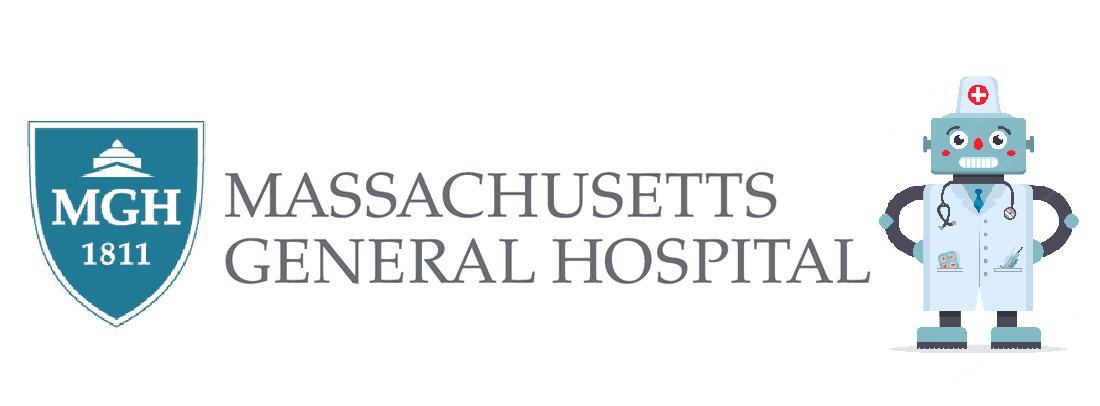

### Sistema de obtención de información con NLTK

Datos

#### 1. Instalar dependencias

In [ ]:
import json
import string
import random 
import numpy as np
import pickle
import re
import unicodedata

import tflearn
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

#### 2 - Herramientas de preprocesamiento de datos

Entre las tareas de procesamiento de texto se implementa:

- Quitar caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [5]:
def preprocess_clean_text(text):    
    # Quito caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # Quito números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [6]:
# Se prueba la funcion de preprocesado.
# Se observa que se eliminan los signos de puntuación, números y caracteres especiales
text = "Okay... Let's try out the preprocessing function with 1 sentence :) Does it work??"
preprocess_clean_text(text.lower())

'okay lets try out the preprocessing function with  sentence  does it work'

#### 3 - Diccionario de entrada

El dataset utilizado para entrenar la red neuronal se encuentra en el archivo `intents.json`. Este contiene: 
- Las posibles preguntas que se le pueden hacer al bot $\rightarrow$  patterns
- Las posibles respuestas del bot $\rightarrow$ responses
- Las posibles categorías de preguntas $\rightarrow$ tag

Se creo el archivo pensando en las posibles preguntas que se le pueden hacer a un bot de una clínica de imágenes médicas y sus posibles respuestas asociadas.

In [7]:
with open('intents.json') as intents:
    data = json.load(intents)

#### 4 - Preprocesamiento y armado del dataset

In [8]:
# Inicializo lematizador
lemmatizer = WordNetLemmatizer()

# Obtenemos información del JSON
vocab = []
classes = []
docs = []
cat = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        # 1. Elimino signos de puntuación, números y caracteres especiales con preprocess_clean_text
        # 2. Divido cada oración del dataset en palabras usando el wordpunct_tokenize de NLTK
        words = nltk.word_tokenize(preprocess_clean_text(pattern))
        # Agrego palabras al vocabulario
        vocab.extend(words)
        # Guardo documentos separados por palabras 
        docs.append(words)
        # Guardo las categorías de los documentos
        cat.append(intent['tag'])

        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [9]:
# Lematización y elimino palabras duplicadas para definir el vocabulario
vocab = [lemmatizer.lemmatize(w.lower()) for w in vocab if w not in "?"]
vocab = sorted(list(set(vocab)))
classes = sorted(classes)

In [10]:
# Imprimo resultados
print("VOCABULARIO:\n", vocab, "\nCantidad de palabras en el vocabulario: ", len(vocab))
print('\n', '-'*125)
print("CLASES DE CONSULTAS:\n", classes, '\n', '-'*125)
print("DOCUMENTOS:\n", docs, '\n', '-'*125)
print("CATEGORÍAS:\n", cat)

VOCABULARIO:
 ['a', 'afternoon', 'agenda', 'am', 'an', 'and', 'appointment', 'april', 'are', 'at', 'available', 'book', 'bye', 'call', 'can', 'case', 'center', 'clinic', 'contact', 'ct', 'date', 'day', 'december', 'direction', 'do', 'echography', 'emergency', 'evening', 'for', 'friday', 'get', 'give', 'go', 'good', 'goodbye', 'have', 'hello', 'help', 'hey', 'hi', 'hospital', 'how', 'i', 'imaging', 'in', 'institution', 'is', 'kid', 'located', 'make', 'march', 'me', 'monday', 'morning', 'mri', 'my', 'need', 'next', 'nice', 'night', 'number', 'of', 'ok', 'on', 'phone', 'please', 'pm', 'provides', 'ray', 'rd', 'require', 'saturday', 'scan', 'schedule', 'service', 'should', 'son', 'suggest', 'suitable', 'tell', 'thank', 'thanks', 'that', 'the', 'there', 'thurday', 'time', 'to', 'tomorrow', 'ultrasound', 'useful', 'very', 'wa', 'want', 'wednesday', 'week', 'what', 'where', 'which', 'x', 'xray', 'you', 'your'] 
Cantidad de palabras en el vocabulario:  103

 -----------------------------------

A continuación, transformaremos los documentos en bag of words (training) y a las clases en un vector de clases multicategórico (output) con One Hot Encoding.

In [11]:
training = []
output = []
out_empty = [0] * len(classes)

# One hot encoding
for idx, doc in enumerate(docs):
    # Para cada documento, lematizo palabras (en minúscula) y hago one hot encoding
    bag = []
    words = [lemmatizer.lemmatize(w.lower()) for w in doc]
    for w in vocab:
        if w in words:
            bag.append(1)
        else:
            bag.append(0)

    output_row = out_empty[:]
    output_row[classes.index(cat[idx])] = 1
    
    training.append(bag)
    output.append(output_row)

training = np.array(training)
output = np.array(output)

#### 5 - Entrenamiento del modelo

In [12]:
# Shape de entrada y salida
input_shape = (training.shape[1],)
output_shape = output.shape[1]
print("Input:", input_shape, "\nOutput:", output_shape)

Input: (103,) 
Output: 7


In [13]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13312     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 22,023
Trainable params: 22,023
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
hist = model.fit(x=training, y=output, epochs=300)

Train on 50 samples
Epoch 1/300
50/50 [==============================] - 0s 2ms/sample - loss: 1.9847 - acc: 0.1200
Epoch 2/300
50/50 [==============================] - 0s 137us/sample - loss: 1.9545 - acc: 0.1200
Epoch 3/300
50/50 [==============================] - 0s 100us/sample - loss: 1.8920 - acc: 0.2600
Epoch 4/300
50/50 [==============================] - 0s 213us/sample - loss: 1.9136 - acc: 0.1800
Epoch 5/300
50/50 [==============================] - 0s 49us/sample - loss: 1.8834 - acc: 0.3600
Epoch 6/300
50/50 [==============================] - 0s 225us/sample - loss: 1.8771 - acc: 0.2200
Epoch 7/300
50/50 [==============================] - 0s 78us/sample - loss: 1.8404 - acc: 0.2600
Epoch 8/300
50/50 [==============================] - 0s 215us/sample - loss: 1.8597 - acc: 0.2600
Epoch 9/300
50/50 [==============================] - 0s 79us/sample - loss: 1.8060 - acc: 0.2800
Epoch 10/300
50/50 [==============================] - 0s 235us/sample - loss: 1.8123 - acc: 0.3600
Epoc

Epoch 84/300
50/50 [==============================] - 0s 100us/sample - loss: 0.4928 - acc: 0.8600
Epoch 85/300
50/50 [==============================] - 0s 0s/sample - loss: 0.5057 - acc: 0.9000
Epoch 86/300
50/50 [==============================] - 0s 103us/sample - loss: 0.4208 - acc: 0.9200
Epoch 87/300
50/50 [==============================] - 0s 0s/sample - loss: 0.3842 - acc: 0.9400
Epoch 88/300
50/50 [==============================] - 0s 89us/sample - loss: 0.3931 - acc: 0.8800
Epoch 89/300
50/50 [==============================] - 0s 0s/sample - loss: 0.5511 - acc: 0.8200
Epoch 90/300
50/50 [==============================] - 0s 135us/sample - loss: 0.3854 - acc: 0.9400
Epoch 91/300
50/50 [==============================] - 0s 180us/sample - loss: 0.4335 - acc: 0.8800
Epoch 92/300
50/50 [==============================] - 0s 148us/sample - loss: 0.3875 - acc: 0.9400
Epoch 93/300
50/50 [==============================] - 0s 74us/sample - loss: 0.3336 - acc: 0.9000
Epoch 94/300
50/50 [=

50/50 [==============================] - 0s 0s/sample - loss: 0.0432 - acc: 1.0000
Epoch 249/300
50/50 [==============================] - 0s 120us/sample - loss: 0.0440 - acc: 1.0000
Epoch 250/300
50/50 [==============================] - 0s 121us/sample - loss: 0.0719 - acc: 1.0000
Epoch 251/300
50/50 [==============================] - 0s 120us/sample - loss: 0.0365 - acc: 1.0000
Epoch 252/300
50/50 [==============================] - 0s 14us/sample - loss: 0.0400 - acc: 1.0000
Epoch 253/300
50/50 [==============================] - 0s 261us/sample - loss: 0.0359 - acc: 1.0000
Epoch 254/300
50/50 [==============================] - 0s 22us/sample - loss: 0.0173 - acc: 1.0000
Epoch 255/300
50/50 [==============================] - 0s 233us/sample - loss: 0.0314 - acc: 1.0000
Epoch 256/300
50/50 [==============================] - 0s 0s/sample - loss: 0.1049 - acc: 0.9800
Epoch 257/300
50/50 [==============================] - 0s 277us/sample - loss: 0.0671 - acc: 0.9800
Epoch 258/300
50/50 [=

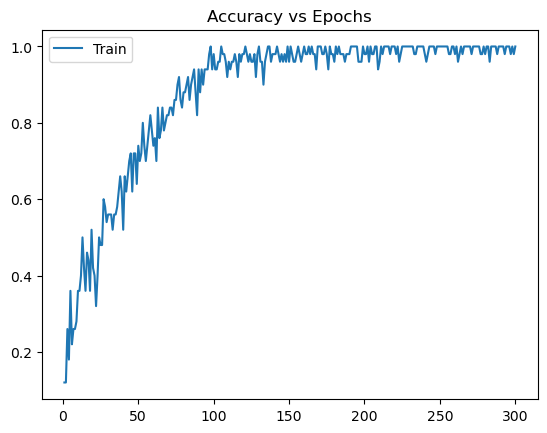

In [15]:
# Grafico entrenamiento
epoch_count = range(1, len(hist.history['acc']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['acc'], label='Train')
plt.title('Accuracy vs Epochs')
plt.show()

In [16]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
pickle.dump(words, open('words.pkl','wb')) # el vocabulario utilizado (words)
pickle.dump(classes, open('classes.pkl','wb')) # las posibles clases
model.save('chatbot_model.h5') # el modelo

#### 6 - Testing y validación

In [17]:
def bag_of_words(text, vocab): 
    tokens = nltk.word_tokenize(preprocess_clean_text(text))
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    return np.array(bow)

            
def pred_class(text, vocab, classes): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # Sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # Es un array de softmax
        thresh = 0.2
        # Filtro aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordeno keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los clases de mayor a menor
        for r in y_pred:
            return_list.append(classes[r[0]])

    # Si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list


def get_response(intents_list, intents_json):
    tag = intents_list[0] # Tomo el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # Busco el tag correspoindiente y doy una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [18]:
def start_chat():
    print("Welcome to the Massachusetts General Hospital ChatBot.\n (Please type 'quit' to exit)")
    while True:
        # Pido input al usuario
        message = input("\nPATIENT: ")
        if message.lower() == 'quit':
            break

        intents = pred_class(message, vocab, classes)
        if len(intents) > 0:
            result = get_response(intents, data)
            print("BOT:", result)
        else: # si no hubo ningún resultado que supere el umbral
            print("BOT: I'm sorry, I didn't understand that. Could you please rephrase?")

Patient 1 Chat

In [20]:
start_chat()

Welcome to the Massachusetts General Hospital ChatBot.
 (Please type 'quit' to exit)

PATIENT: hello!
BOT: Hi there! How may I help you?

PATIENT: i need to make an appointment for my son
BOT: Sure thing. Please detail the type of appointment: X-ray, MRI, CT or ultrasound

PATIENT: MRI
BOT: Sure. When are you planning on having the test done?

PATIENT: Monday at 2pm
BOT: Appointment scheduled!

PATIENT: I want to make another appointment for myself
BOT: Sure! I can help you with that. Please provide me with some extra details.

PATIENT: I want to schedule a head MRI
BOT: Sure. When are you planning on having the test done?

PATIENT: Next month. June 12 or 13
BOT: I'm sorry, but that date and time is fully booked. Please let me know another convinient date and time for the appointment

PATIENT: And on thursday 15th?
BOT: Awesome! Your appointment is booked!

PATIENT: thank you!
BOT: Goodbye. Thank you for contacting Massachusetts General Hospital.

PATIENT: quit


Patient 2 Chat

In [24]:
start_chat()

Welcome to the Massachusetts General Hospital ChatBot.
 (Please type 'quit' to exit)

PATIENT: good evening
BOT: Hey! How can I be of service?

PATIENT: i have an emergency
BOT: You can contact our imaging center at +1 617-726-2000.

PATIENT: i need a doctor right now
BOT: Sure! I can help you with that. Please provide me with some extra details.

PATIENT: i feel sick
BOT: Sure thing. Please detail the type of appointment: X-ray, MRI, CT or ultrasound

PATIENT: why?
BOT: I'm sorry, I didn't understand that. Could you please rephrase?

PATIENT: quit


#### 7 - Conclusiones

El bot tal cual está definido es capaz de responder a bastantes preguntas tipicas sobre un turno médico con gran precisión, como se observa en el primer chat. 

Cuando el paciente consulta con palabras dentro del vocabulario, el chatbot responde bien. Sin embargo, cuando se hacen consultas que no están contempladas en el JSON, las respuestas no son muy acertadas. En particular, en el segundo chat se tiene el input "`i feel sick`". La red corresponde este mensaje con la categoría "appointment". Si bien la respuesta no tiene mucho sentido, la categoría elegida dentro de las disponibles podría considerarse la más acertada. Por otro lado, se tiene el input "`why?`", y como esta palabra no se encuentra dentro del vocabulario, la red no sabe a que categoría asignarla, por lo cuál se responde de forma predeterminada.

Se podría decir que la desventaja principal de este BOT es que las respuestas son bastante genéricas, ya que las selecciona desde las responses predefinidas en el JSON. Además, si se hace una consulta con palabras que no se encuentran dentro de los patrones del JSON, no habrá una buena respuesta. Por lo tanto, una manera de mejorarlo es pensar en muchos casos de uso y generar un JSON más completo. Otra opción a este bot podría ser utilizar TF-IDF en vez de bag of words.